##Pyeeg has been installed

In [ ]:
pip install git+https://github.com/forrestbao/pyeeg.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-4np090wz
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-4np090wz
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28133 sha256=77d87ae1c7e416a458a13a7a03a85c03c38681e6bcce1469dda2bc9a77869ed2
  Stored in directory: /tmp/pip-ephem-wheel-cache-r4yeqisv/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg


## Here the code is mounted with google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyeeg

## Imported the necessery library packages

In [ ]:
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
#import tensorflow as tf
import time

##  Intialize the channel array, band array, window_size, step_size and sample_rate and set the path of dataset of google drive. [N.B. In experiment 1(model architecture-1) the window_size, step_size, sample rate have been changed  and in experiment 5(model architecture-5) only window_size has been change at the time of feature extraction.]

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+

band = [4,8,12,16,25,45] #5 bands

window_size = 256 #Averaging band power of 2 sec

step_size = 16 #Each 0.125 sec update once

sample_rate = 128 #Sampling rate of 128 Hz

subjectList=[]
for i in range(1,33):
  if i<10:
     subjectList.append(f"{i:02d}")
  else:
    subjectList.append(f"{i:2d}")

print(subjectList)

#List of subjects
path_to_dataset_2 = '/content/drive/MyDrive/Thesis/DEAP-dataset/Datasets/dat_File_Folder/'
path_to_dataset = '/content/drive/MyDrive/Thesis/DEAP-dataset/Datasets/model_5_Khosru/'

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']


##Plot raw EEG signal

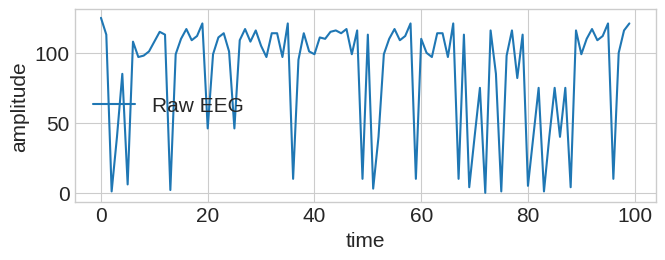

In [ ]:
dat_file_path = path_to_dataset_2 + "s01.dat"

s01_np = np.fromfile(dat_file_path, dtype='byte')

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (7.5,2.5)
plt.rcParams.update({'font.size': 15})

#plt.style.use('bmh')

#plt.style.use('default')

plt.style.use('seaborn-whitegrid')

t = np.arange(0, 100, 1)
  
EEG_s01 = s01_np[:100]

plt.figure()
plt.plot(t, EEG_s01, label="Raw EEG")

plt.xlabel("time")
plt.ylabel("amplitude")
plt.legend(loc="center left")

##A function has been created for feature extraction using Fast Fourier Transformation. Here the parameters are recieved  values for subjects, channel, band, window_size, step_size and sample rate values. And the files are opened according to path what has been set above. And extracted files have been saved to the set path.

In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open(path_to_dataset_2+'s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        #np.save('C:/Users/faizan/Downloads/data_preprocessed_python/data_preprocessed_python/s' + sub, meta, allow_pickle=True, fix_imports=True)
        np.save(path_to_dataset+'s' + sub, meta, allow_pickle=True, fix_imports=True)

## Created feature extraction function has been called from here

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Modify the default parameters of np.load

In [ ]:
import numpy as np
# save np.load
np_load_old = np.load


np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


## Here all the data are segmented into training set and test set. This has been done following 7:1 ratio for train and test.

In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(path_to_dataset + 's' + subjects + '.npy', 'rb') as file:
        sub = np.load(file)
        for i in range (0,sub.shape[0]):
            if i % 8 == 0:
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
            else:
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])
          

## restore np.load for future normal usage

In [ ]:

np.load = np_load_old

## All the training data and test data have been saved in the google drive according to path.

In [ ]:
np.save(path_to_dataset + 'data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(path_to_dataset + 'data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (546560, 70) (546560, 4)
testing dataset: (78080, 70) (78080, 4)


## Here all the training file have been loaded .The data have been put in variable X and label values have been put in Y.Then the X has been Normalized and then arousal label values have been loaded in Z. And then all the '9' values are converted into '8.99' of arousal label.

In [ ]:
with open(path_to_dataset + 'data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [0]])


Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

for i in range(len(Z)):
  if Z[i] == 9:
    Z[i] = 8.99

## Here all the training file have been loaded .The data have been put in variable X and label values have been put in Y.Then the X has been Normalized and then valence label values have been loaded in Z. And then all the '9' values are converted into '8.99' of valence label.

In [ ]:
with open(path_to_dataset + 'data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [1]])


Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

for i in range(len(Z)):
  if Z[i] == 9:
    Z[i] = 8.99

In [ ]:
np.unique(Z)

array([1.  , 1.01, 1.03, 1.05, 1.06, 1.13, 1.17, 1.18, 1.19, 1.23, 1.29,
       1.41, 1.55, 1.68, 1.72, 1.77, 1.78, 1.79, 1.82, 1.85, 1.91, 1.92,
       1.94, 1.95, 1.96, 1.97, 1.99, 2.  , 2.01, 2.03, 2.04, 2.05, 2.06,
       2.08, 2.09, 2.1 , 2.13, 2.14, 2.18, 2.23, 2.24, 2.26, 2.27, 2.32,
       2.35, 2.36, 2.41, 2.5 , 2.51, 2.55, 2.6 , 2.62, 2.69, 2.73, 2.74,
       2.76, 2.77, 2.78, 2.79, 2.81, 2.82, 2.83, 2.85, 2.87, 2.88, 2.9 ,
       2.91, 2.92, 2.94, 2.95, 2.96, 2.97, 2.99, 3.  , 3.01, 3.03, 3.04,
       3.05, 3.06, 3.08, 3.09, 3.1 , 3.12, 3.13, 3.14, 3.15, 3.17, 3.19,
       3.23, 3.24, 3.26, 3.28, 3.29, 3.31, 3.32, 3.35, 3.37, 3.38, 3.44,
       3.45, 3.46, 3.47, 3.49, 3.53, 3.54, 3.6 , 3.62, 3.63, 3.64, 3.68,
       3.69, 3.71, 3.73, 3.74, 3.77, 3.78, 3.79, 3.81, 3.82, 3.83, 3.85,
       3.86, 3.87, 3.88, 3.9 , 3.91, 3.92, 3.94, 3.95, 3.96, 3.97, 3.99,
       4.  , 4.01, 4.03, 4.04, 4.05, 4.06, 4.08, 4.09, 4.1 , 4.12, 4.13,
       4.14, 4.15, 4.17, 4.21, 4.22, 4.23, 4.24, 4.

In [ ]:
np.unique(Z)

array([1.  , 1.01, 1.03, 1.05, 1.06, 1.13, 1.17, 1.18, 1.19, 1.23, 1.29,
       1.41, 1.55, 1.68, 1.72, 1.77, 1.78, 1.79, 1.82, 1.85, 1.91, 1.92,
       1.94, 1.95, 1.96, 1.97, 1.99, 2.  , 2.01, 2.03, 2.04, 2.05, 2.06,
       2.08, 2.09, 2.1 , 2.13, 2.14, 2.18, 2.23, 2.24, 2.26, 2.27, 2.32,
       2.35, 2.36, 2.41, 2.5 , 2.51, 2.55, 2.6 , 2.62, 2.69, 2.73, 2.74,
       2.76, 2.77, 2.78, 2.79, 2.81, 2.82, 2.83, 2.85, 2.87, 2.88, 2.9 ,
       2.91, 2.92, 2.94, 2.95, 2.96, 2.97, 2.99, 3.  , 3.01, 3.03, 3.04,
       3.05, 3.06, 3.08, 3.09, 3.1 , 3.12, 3.13, 3.14, 3.15, 3.17, 3.19,
       3.23, 3.24, 3.26, 3.28, 3.29, 3.31, 3.32, 3.35, 3.37, 3.38, 3.44,
       3.45, 3.46, 3.47, 3.49, 3.53, 3.54, 3.6 , 3.62, 3.63, 3.64, 3.68,
       3.69, 3.71, 3.73, 3.74, 3.77, 3.78, 3.79, 3.81, 3.82, 3.83, 3.85,
       3.86, 3.87, 3.88, 3.9 , 3.91, 3.92, 3.94, 3.95, 3.96, 3.97, 3.99,
       4.  , 4.01, 4.03, 4.04, 4.05, 4.06, 4.08, 4.09, 4.1 , 4.12, 4.13,
       4.14, 4.15, 4.17, 4.21, 4.22, 4.23, 4.24, 4.

## All the training label values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values. This approch is maintained for both arousal and valence Binary classifications  but not for eight class classification.

In [ ]:
count_0 = 0
count_1 = 0
for i in range(len(Z)):
  if Z[i] >= 1 and Z[i]<=4.99:
    Z [i] = 0
    count_0 = count_0 + 1
  else:
    Z [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

## Necessery some another libraries are imported

In [ ]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
#from keras.utils import to_categorical 
from keras.utils.np_utils import to_categorical
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from keras.optimizers import SGD
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

## Here all the training label values are categorised. For binary classification and it is catagorised into two catagory. value range 1 - 4.99 have been assigned in catagory '0' and rest of the value are assigned in catagory '1'. 
## This catagorised approach has been demonstrated 8 catagories in 8 class classifications Where values
## 1 - 1.99 ----> catagory(0)
## 2 - 2.99 ----> catagory(1)
## 3 - 3.99 ----> catagory(2)
## 4 - 4.99 ----> catagory(3)
## 5 - 5.99 ----> catagory(4)
## 6 - 6.99 ----> catagory(5)
## 7 - 7.99 ----> catagory(6)
## 8 - 8.99 ----> catagory(7)

In [ ]:
#from keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
y_train = to_categorical(Z)
y_train = y_train[:,1:]
y_train[:10]

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

## Values of X  are put in x_train as numpy array format

In [ ]:
x_train = np.array(X[:])

##Here all the testing file have been loaded .The data have been put in variable M and label values have been put in N.Then the M has been Normalized and then arousal label values have been loaded in L. And then all the '9' values are converted into '8.99' of arousal label.

In [ ]:
with open(path_to_dataset + 'data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [0]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

for i in range(len(L)):
  if L[i] == 9:
    L[i] = 8.99

##Here all the testing file have been loaded .The data have been put in variable M and label values have been put in N.Then the M has been Normalized and then valence label values have been loaded in L. And then all the '9' values are converted into '8.99' of valence label.

In [ ]:
with open(path_to_dataset + 'data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [1]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

for i in range(len(L)):
  if L[i] == 9:
    L[i] = 8.99

## All the testing labels values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values. This approch is maintained for both arousal and valence binary classifications but not for the eight class classification.

In [ ]:
count_0 = 0
count_1 = 0
for i in range(len(L)):
  if L[i] >= 1 and L[i]<=4.99:
    L [i] = 0
    count_0 = count_0 + 1
  else:
    L [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

## Vules of M are assigned in x_test in numpy array format

In [ ]:
x_test = np.array(M[:])
x_test

array([[0.07006464, 0.10438554, 0.06634758, ..., 0.10698754, 0.14264875,
        0.12007955],
       [0.07546743, 0.08606705, 0.07999725, ..., 0.12147734, 0.13970255,
        0.12824657],
       [0.11370435, 0.09387804, 0.07056466, ..., 0.11339237, 0.11484593,
        0.10770615],
       ...,
       [0.17484635, 0.1135094 , 0.05917121, ..., 0.03334964, 0.05135839,
        0.07198122],
       [0.20681713, 0.10186689, 0.0540274 , ..., 0.02499636, 0.05249084,
        0.05879238],
       [0.17817637, 0.08834064, 0.05389381, ..., 0.03475489, 0.05801423,
        0.06873259]])

## Here all the tessting labels values are categorised. For binary classification  and it is catagorised into two catagory. value range 1 - 4.99 have been assigned in catagory '0' and rest of the value are assigned in catagory '1'. 
## This catagorised approach has been demonstrated 8 catagories in 8 class classifications Where values
## 1 - 1.99 ----> catagory(0)
## 2 - 2.99 ----> catagory(1)
## 3 - 3.99 ----> catagory(2)
## 4 - 4.99 ----> catagory(3)
## 5 - 5.99 ----> catagory(4)
## 6 - 6.99 ----> catagory(5)
## 7 - 7.99 ----> catagory(6)
## 8 - 8.99 ----> catagory(7)

In [ ]:
#from keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
y_test = to_categorical(L)
y_test = y_test[:,1:]
y_test[:10]

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
y_test[54000:54000+10]

array([[0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

## Fit the train and test data with StandarScaler

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

## Two dimensional data are converted into three dimension by adding one constant dimension’s value '1'

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
x_train.shape

(546560, 70, 1)

In [ ]:
x_train.shape

(546560, 70, 1)

## Here define the batch_size, number of class used in model architecture ,how many epoch will be run with the model and also define the input_shape. In experiment 4 (model architecture - 4)the batch_size has been tunned with 128,  256, 512  and in experiment 5 (model architecture - 5) the batch_size has been tunned with 128, 256, 512. 

In [ ]:
batch_size = 256
num_classes = 8
epochs = 120
input_shape=(x_train.shape[1], 1)

In [ ]:
print(input_shape)

(70, 1)


## import another library packages

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

## Model 1
This is model architecture 1 and this architecture has been used for experiment 1

In [ ]:
model = Sequential()
intput_shape=(x_train.shape[1], 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
#model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
#model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

## Model 2
This is model architecture 2 and this architecture has been used for experiment 2

In [ ]:
model = Sequential()
intput_shape=(x_train.shape[1], 1)
model.add(Conv1D(256, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


## Model 3
This is model architecture 3 and this architecture has been used for experiment 3

In [ ]:
model = Sequential()
intput_shape=(x_train.shape[1], 1)
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(32,kernel_size=3,padding = 'same', activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

## Model 4
This is model architecture 4 and this architecture has been used for experiment 4

In [ ]:
model = Sequential()
intput_shape=(x_train.shape[1], 1)
model.add(Conv1D(512, kernel_size=9,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=6,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(32,kernel_size=3,padding = 'same', activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

## Model 5
This is model architecture 5 and this architecture has been used for experiment 5

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='hard_sigmoid'))

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)


## Model 6
This is model architecture 6 and this architecture has been used for experiment 6 and this is our final model which is used for binary and eight class classification.

In [ ]:
model = Sequential()

intput_shape=(x_train.shape[1], 1)

model.add(Conv1D(1024, kernel_size=9,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(512,kernel_size=6,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(256,kernel_size=6,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(128,kernel_size=6,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 70, 1024)          10240     
_________________________________________________________________
batch_normalization (BatchNo (None, 70, 1024)          4096      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 35, 1024)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 512)           3146240   
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 512)           2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 17, 512)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 17, 256)           7

## compile the model 

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

## Plot all the specifications of model architecture

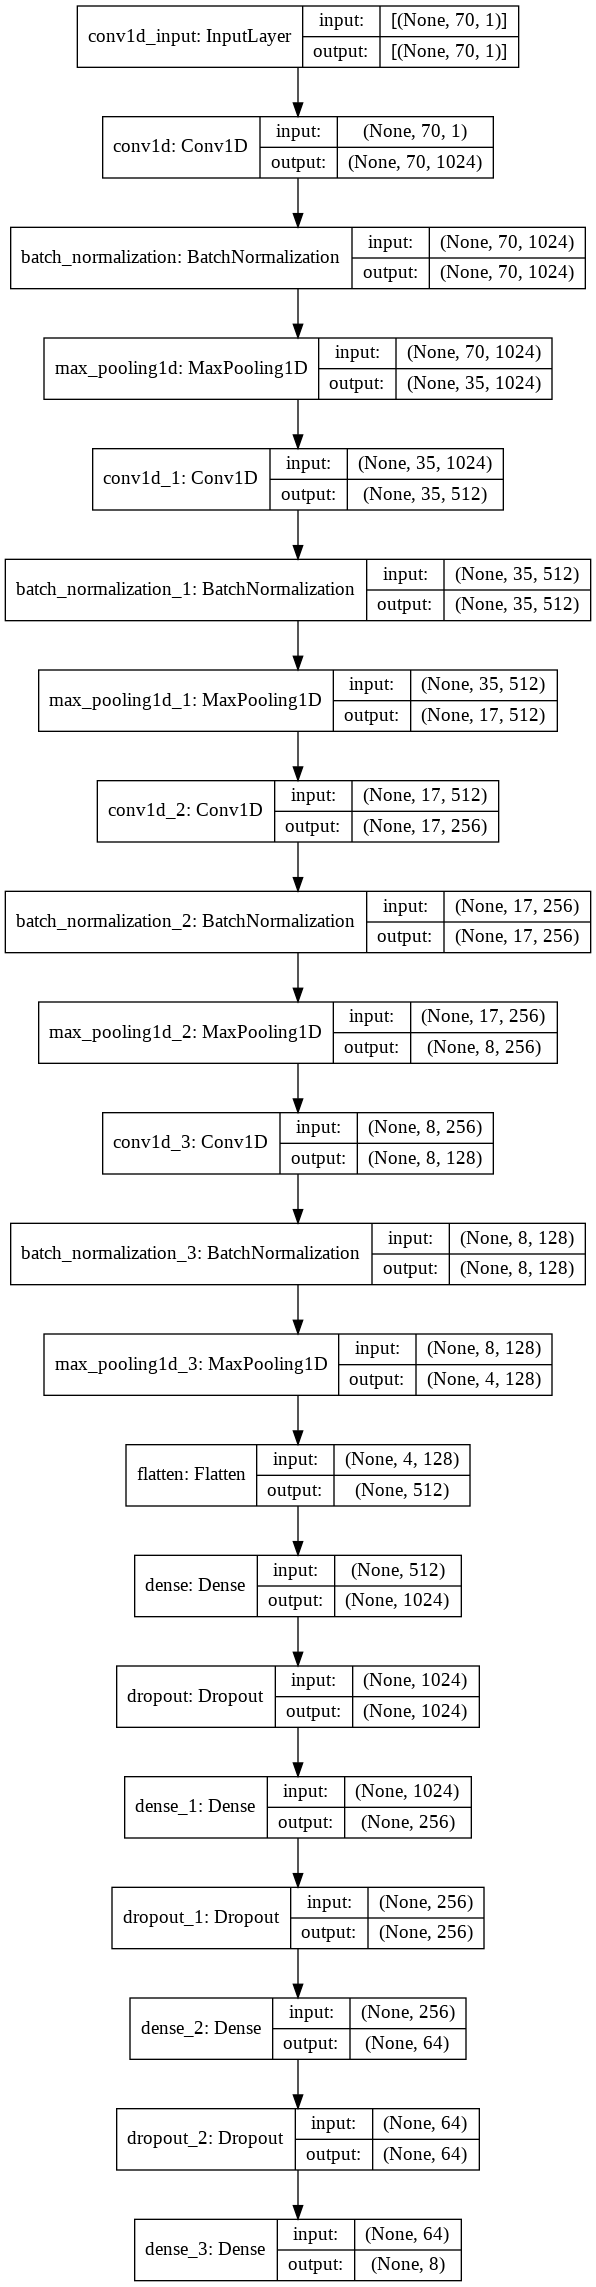

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Automatic save 

## We have saved all the details of every epoch in google drive so that we can use this when we need.

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/MyDrive/Thesis/DEAP-dataset/Saved_checkpoints_2/Copy_Valance_Check_point_2/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=15)
callbacks_list = [es, checkpoint]

/content/drive/MyDrive/Thesis/DEAP-dataset/Saved_checkpoints_2/Copy_Valance_Check_point_2/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


## Fit the model 

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks= callbacks_list)

Epoch 1/120
2135/2135 [==============================] - 145s 53ms/step - loss: 1.7702 - accuracy: 0.3062

Epoch 00001: accuracy improved from -inf to 0.34842, saving model to /content/drive/MyDrive/Thesis/DEAP-dataset/Saved_checkpoints_2/Copy_Valance_Check_point_2/weights-improvement-01-0.3484.hdf5
Epoch 2/120
2135/2135 [==============================] - 113s 53ms/step - loss: 1.4084 - accuracy: 0.4489

Epoch 00002: accuracy improved from 0.34842 to 0.47504, saving model to /content/drive/MyDrive/Thesis/DEAP-dataset/Saved_checkpoints_2/Copy_Valance_Check_point_2/weights-improvement-02-0.4750.hdf5
Epoch 3/120
2135/2135 [==============================] - 113s 53ms/step - loss: 1.1452 - accuracy: 0.5574

Epoch 00003: accuracy improved from 0.47504 to 0.57593, saving model to /content/drive/MyDrive/Thesis/DEAP-dataset/Saved_checkpoints_2/Copy_Valance_Check_point_2/weights-improvement-03-0.5759.hdf5
Epoch 4/120
2135/2135 [==============================] - 113s 53ms/step - loss: 0.9455 - ac

## Find the accuracy after completing the model train

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2440/2440 [==============================] - 10s 4ms/step - loss: 0.3243 - accuracy: 0.9383
Test loss: 0.32428452372550964
Test accuracy: 0.9383324980735779


##Manual save 

In [ ]:
base_path_model = "/content/drive/My Drive/Google_Colab/Autoencoder/saved_models/" 
accuracy = "_89"

path_model = base_path_model + model_name + accuracy + ".h5"
model.save(path_model)

##Find the accuracy from a savepoint

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/MyDrive/Thesis/DEAP-dataset/Saved_checkpoints_2/Copy_Valance_Check_point_2/weights-improvement-120-0.9857.hdf5')
score = model_loaded.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2440/2440 [==============================] - 55s 5ms/step - loss: 0.3243 - accuracy: 0.9383
Test loss: 0.3242845833301544
Test accuracy: 0.9383324980735779


##Training loss graph

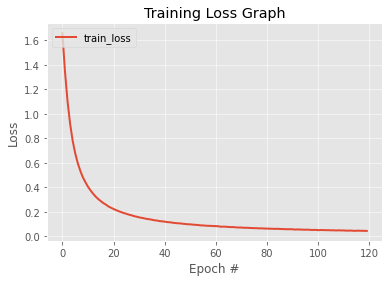

In [ ]:
N = num_classes
EPOCS = 120
# construct a plot that plots and saves the training history
import matplotlib.pyplot as plt
N = np.arange(0, EPOCS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
#plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss Graph")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()
#base_path_graphs = '/content/drive/My Drive/Google_Colab/Autoencoder/Graphs/'
#path_loss_acc = base_path_graphs + model_name + 'Train_loss_Val_loss.png'
#plt.savefig(base_path_graphs, dpi=1000, bbox_inches='tight')
#files.download( "Train_Accuracy.png" )

##Training accuracy graph

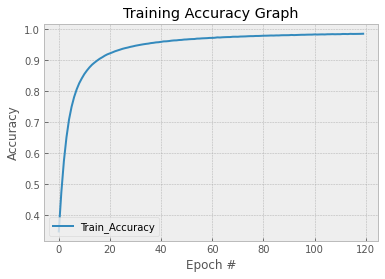

In [ ]:
N = num_classes
EPOCS = 120
# construct a plot that plots and saves the training history
import matplotlib.pyplot as plt
N = np.arange(0, EPOCS)
plt.style.use("bmh")
plt.figure()
plt.plot(N, H.history["accuracy"], label="Train_Accuracy")
#plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Accuracy Graph")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

##Training Loss & Training Accuracy graph

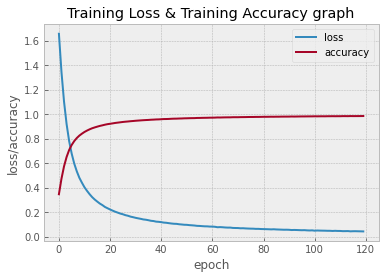

In [ ]:
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['accuracy'])
plt.title('Training Loss & Training Accuracy graph')
plt.ylabel('loss/accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper right')
plt.show()

## Create Confusion matrix plotting function 

In [ ]:
from sklearn.utils.multiclass import unique_labels
from matplotlib import pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

##Confusion matrix plotting function call

Confusion matrix, without normalization
[[ 5926    65    43    49    41    66    64    29]
 [   60  6572    56    64    73    87    64    39]
 [   49    77  8590    79   110   148    70    27]
 [   60    58    86  9040   102   150    98    44]
 [   68    57   105   159 12689   249   152    63]
 [   70    70    79   137   177 13509   210    83]
 [   75    67    68    94   121   223 11328   102]
 [   67    41    34    46    64    89    87  5611]]
Normalized confusion matrix
[[0.94 0.01 0.01 0.01 0.01 0.01 0.01 0.  ]
 [0.01 0.94 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.94 0.01 0.01 0.02 0.01 0.  ]
 [0.01 0.01 0.01 0.94 0.01 0.02 0.01 0.  ]
 [0.01 0.   0.01 0.01 0.94 0.02 0.01 0.  ]
 [0.   0.   0.01 0.01 0.01 0.94 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.02 0.94 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.93]]


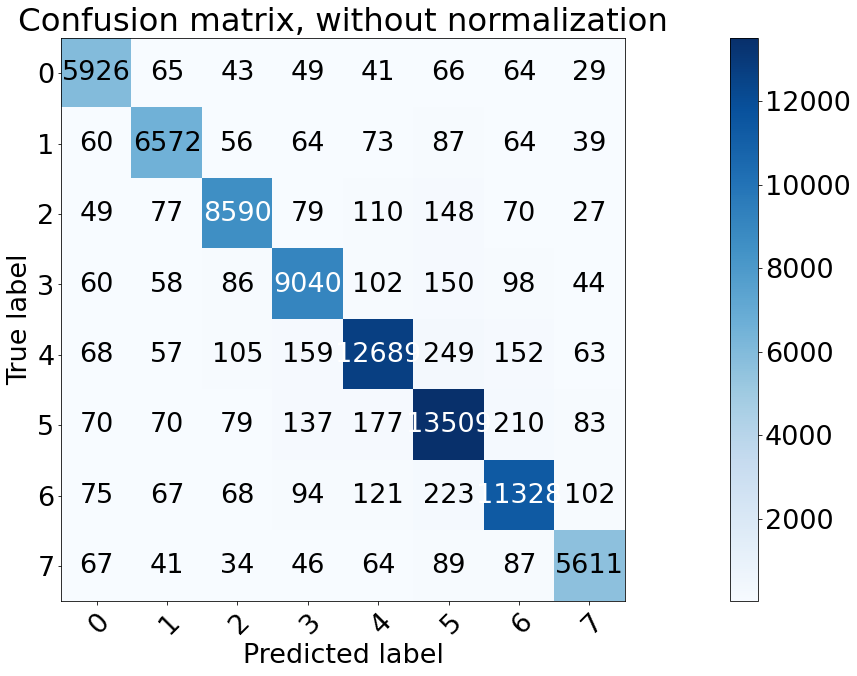

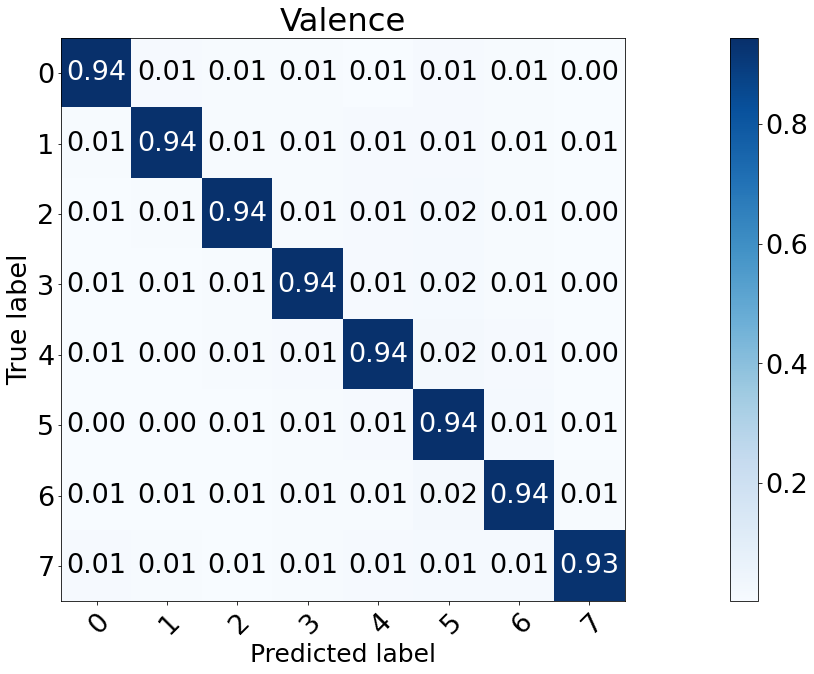

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,10)
plt.rcParams.update({'font.size': 27})

from sklearn.metrics import confusion_matrix

y_pred = model_loaded.predict(x_test)
y_test_argmax = y_test.argmax(axis=1)
y_pred_argmax = y_pred.argmax(axis=1)

class_names = np.array([0,1, 2, 3, 4, 5, 6, 7])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_argmax, y_pred_argmax, classes=class_names, normalize=True,
                      title='Valence')
#fig = plt.figure(figsize=(20 ,20), dpi=300) 
plt.xlabel('Predicted label', fontsize=25)
plt.show()
#plt.figure(figsize=(40, 40))


## Classification report demonstrating

In [ ]:

y_true = np.array(y_test)

y_pred = np.squeeze(model.predict(x_test))
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.94      0.94      6283
           1       0.94      0.93      0.94      7015
           2       0.95      0.94      0.94      9150
           3       0.94      0.94      0.94      9638
           4       0.95      0.93      0.94     13542
           5       0.94      0.94      0.94     14335
           6       0.94      0.94      0.94     12078
           7       0.94      0.93      0.93      6039

   micro avg       0.94      0.94      0.94     78080
   macro avg       0.94      0.94      0.94     78080
weighted avg       0.94      0.94      0.94     78080
 samples avg       0.94      0.94      0.94     78080



## Load model from a save point

In [ ]:

from keras.models import load_model
model_loaded = load_model('/content/drive/MyDrive/Thesis/DEAP-dataset/Saved_checkpoints_2/Copy_Valance_Check_point_2/weights-improvement-120-0.9857.hdf5')

H = model_loaded.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split = 0.2,
          callbacks= callbacks_list)

Epoch 1/120
1708/1708 [==============================] - 95s 55ms/step - loss: 0.0492 - accuracy: 0.9845 - val_loss: 0.0096 - val_accuracy: 0.9970

Epoch 00001: accuracy did not improve from 0.98573
Epoch 2/120
1708/1708 [==============================] - 94s 55ms/step - loss: 0.0459 - accuracy: 0.9854 - val_loss: 0.0140 - val_accuracy: 0.9957

Epoch 00002: accuracy did not improve from 0.98573
Epoch 3/120
1708/1708 [==============================] - 94s 55ms/step - loss: 0.0443 - accuracy: 0.9857 - val_loss: 0.0150 - val_accuracy: 0.9956

Epoch 00003: accuracy did not improve from 0.98573
Epoch 4/120
1708/1708 [==============================] - 94s 55ms/step - loss: 0.0452 - accuracy: 0.9857 - val_loss: 0.0297 - val_accuracy: 0.9911

Epoch 00004: accuracy did not improve from 0.98573
Epoch 5/120
1708/1708 [==============================] - 93s 55ms/step - loss: 0.0448 - accuracy: 0.9860 - val_loss: 0.0268 - val_accuracy: 0.9915

Epoch 00005: accuracy improved from 0.98573 to 0.98601, 

KeyboardInterrupt: ignored

## Test accuracy from a saving point

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/drive/MyDrive/Thesis/DEAP-dataset/Saved_checkpoints_2/Copy_Valance_Check_point_2/weights-improvement-115-0.9854.hdf5')
score = model_loaded.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])